In [13]:
import math
import os
import time
import numpy as np
import pandas as pd

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam, SGD
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LayerNormalization, Activation
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from typing import Tuple


from engineering import feature_engineering as fe

In [2]:

def create_dataframe_from_data(input_path: str) -> pd.DataFrame:
    dataframes = []
    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)

        data = np.load(file_path, allow_pickle=True)
        df = pd.DataFrame(data)

        gesture = file_name.split("_")[0]
        gesture_index = int(file_name.split("_")[1].split(".")[0]) 

        # Adds 2 new columns to df 
        df["gesture"] = gesture 
        df["gesture_index"] = gesture_index 

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True) if len(dataframes) > 0 else ValueError("Dataframe is empty")

def create_dict_from_df(df: pd.DataFrame) -> dict:
    diction = {x: [] for x in np.unique(df["gesture"].values.tolist())}
    for gesture_index, gesture_data in df.groupby("gesture_index"):
        gesture = np.unique(gesture_data["gesture"].values.tolist())[0]
        tmp = diction[gesture] + [gesture_index]
        diction.update({gesture:tmp})
    return diction

def split_dataset(df: pd.DataFrame, target_label: str, additional_targets: list=None, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15) -> \
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    assert train_ratio + val_ratio + test_ratio == 1.0, "ratios must sum to 1."

    gesture_index_dict = create_dict_from_df(df)

    train_indices, val_indices, test_indices = [], [], []

    for _, indices in gesture_index_dict.items():
        n_total = len(indices)
        n_train, n_val = math.ceil(n_total * train_ratio), math.ceil(n_total * test_ratio)

        train_indices.extend(indices[:n_train])
        val_indices.extend(indices[n_train:n_train+n_val])
        test_indices.extend(indices[n_train+n_val:])
    
    grouped_data = df.groupby("gesture_index")

    train_frames, val_frames, test_frames = [], [], []
    for idx in train_indices:
        train_frames.append(grouped_data.get_group(idx))
    for idx in val_indices:
        val_frames.append(grouped_data.get_group(idx))
    for idx in test_indices:
        test_frames.append(grouped_data.get_group(idx))

    # Concatenate the dataframes to create the final train and test sets
    train_set = pd.concat(train_frames).reset_index(drop=True)
    val_set = pd.concat(val_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    def split_data(data: pd.DataFrame, target_label: str, additional_targets=None):
        X = data.drop(columns=[target_label])
        y = data[[target_label] + additional_targets] if additional_targets else data[[target_label]]
        return X, y

    X_train, y_train = split_data(train_set, target_label, additional_targets)
    X_val, y_val = split_data(val_set, target_label, additional_targets)
    X_test, y_test = split_data(test_set, target_label, additional_targets)

    return X_train, y_train, X_val, y_val, X_test, y_test

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list) -> pd.DataFrame:
    df_copy = df.copy()
    _ = fe.calculate_temporal_features(df_copy, landmark_cols)
    df_combined = df_copy.loc[:, ~df_copy.columns.duplicated()] # removed any duplicate columns
    return df_combined

def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def augment_model(df: pd.DataFrame, y_df: pd.DataFrame, noise_level=0.0, translation_vector=None, rotation_angle=0.0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_augmented = df.copy()

    landmark_columns = [f"{col}" for col in df_augmented.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
    num_body_parts = ("h", "p", "l", "r")

    x_columns = [col for col in landmark_columns if any(col.startswith(f'{i}x') for i in num_body_parts)] # this way works because of how i is defined before hand... don't really know
    y_columns = [col for col in landmark_columns if any(col.startswith(f'{i}y') for i in num_body_parts)]
    z_columns = [col for col in landmark_columns if any(col.startswith(f'{i}z') for i in num_body_parts)]

    # Add noise
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, df[x_columns + y_columns + z_columns].shape)
        df_augmented[x_columns + y_columns + z_columns] += noise

    # Apply translation
    if translation_vector is not None:
        for i, col in enumerate(x_columns):
            df_augmented[col] += translation_vector[i % 3]
        for i, col in enumerate(y_columns):
            df_augmented[col] += translation_vector[i % 3]
        for i, col in enumerate(z_columns):
            df_augmented[col] += translation_vector[i % 3]

    # Apply rotation around the Z-axis
    if rotation_angle != 0:
        angle_radians = np.radians(rotation_angle)
        cos_angle = np.cos(angle_radians)
        sin_angle = np.sin(angle_radians)

        for col in x_columns:
            y_col = col.replace('x', 'y')
            df_augmented[col], df_augmented[y_col] = (cos_angle * df_augmented[col] - sin_angle * df_augmented[y_col],
                                                      sin_angle * df_augmented[col] + cos_angle * df_augmented[y_col])
    
    # making the gesture index of the augment different - will be added back to the the df
    # will need to double up on the y train and test as well - in reshape_y_labels
    if "gesture_index" in df_augmented.columns:
        cur_time = time.time_ns()
        df_augmented["gesture_index"] += cur_time

    return df_augmented, pd.concat([y_df, y_df]).reset_index(drop=True)

def transform_to_sequenceses(df: pd.DataFrame, sequence_length, target: str, additional_targets: list = None):
    sequences = []
    labels = []
    grouped = df.groupby('remainder__gesture_index')
    
    for _, group in grouped:
        group = group.sort_values('num__frame').reset_index(drop=True)
        for i in range(0, len(group) - sequence_length + 1, sequence_length):
            sequence = group.iloc[i:i+sequence_length].drop(columns=['remainder__gesture_index', target] + (additional_targets if additional_targets else [])).values
            if len(sequence) == sequence_length:
                sequences.append(sequence)
                labels.append(group.iloc[0][target]) if additional_targets is None else labels.append(group.iloc[0][[target] + additional_targets])
    return np.array(sequences), np.array(labels)

# Assuming the target column name is 'gesture' and no additional targets
def create_sequences_with_labels(X_transformed, y, sequence_length) -> Tuple[np.ndarray, np.ndarray]:
    # Combine features and labels into a single DataFrame
    combined_df = pd.concat([pd.DataFrame(X_transformed), y.reset_index(drop=True)], axis=1)
    
    # Convert the DataFrame to sequences
    X_sequences, y_sequences = transform_to_sequenceses(combined_df, sequence_length, target='gesture')
    
    return X_sequences, y_sequences



In [3]:

input_path = r"C:\Users\Gen3r\Documents\capstone\ml_model\data\data_3"
dataframe = create_dataframe_from_data(input_path)
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataframe, target_label='gesture')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
derived_features =  [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns + derived_features     
res = [item for item in landmark_columns if item.startswith(("r", "l"))]

# only augment train
X_train_augmented, y_train = augment_model(X_train, y_train, noise_level=0.05, translation_vector=[0.6, -0.5, 0.05], rotation_angle=45)
X_train_combined = pd.concat([X_train, X_train_augmented], axis=0, ignore_index=True)

# note, features should be applied to both training and other sets, but for feature looking ahead in the data - time series feastures, only apply it to train
X_train_fe = calculate_hand_motion_features(X_train_combined, res)
X_val_fe = calculate_hand_motion_features(X_val, res)
X_test_fe = calculate_hand_motion_features(X_test, res)

preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
X_train_transformed = preprocessor.fit_transform(X_train_fe)
X_val_transformed = preprocessor.transform(X_val_fe)
X_test_transformed = preprocessor.transform(X_test_fe)

print(X_train_transformed.shape, y_train.shape, X_val_transformed.shape, y_val.shape, X_test_transformed.shape, y_test.shape)

# Define sequence length
sequence_length = 30  # or whatever is appropriate

# Create sequences for training, validation, and testing
X_train_sequences, y_train_sequences = create_sequences_with_labels(X_train_transformed, y_train, sequence_length)
X_val_sequences, y_val_sequences = create_sequences_with_labels(X_val_transformed, y_val, sequence_length)
X_test_sequences, y_test_sequences = create_sequences_with_labels(X_test_transformed, y_test, sequence_length)

# Print shapes to verify
print(X_train_sequences.shape)
print(X_val_sequences.shape)
print(X_test_sequences.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

class_labels = np.unique(y_test_sequences.tolist())
class_labels

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sequences)
y_val_encoded = label_encoder.transform(y_val_sequences)
y_test_encoded = label_encoder.transform(y_test_sequences)

y_train_categorical = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))


print(y_train_categorical.shape)
print(y_val_categorical.shape)
print(y_test_categorical.shape)


(7320, 1667) (7320, 1) (1650, 1667) (1650, 1) (1470, 1667) (1470, 1)
(14640, 2045) (14640, 1) (1650, 2045) (1650, 1) (1470, 2045) (1470, 1)
(488, 30, 2044)
(55, 30, 2044)
(49, 30, 2044)
(14640, 1)
(1650, 1)
(1470, 1)
(488, 5)
(55, 5)
(49, 5)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.2101 - loss: 1.8609 - val_accuracy: 0.0000e+00 - val_loss: 1.6976 - learning_rate: 1.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.2446 - loss: 1.6964 - val_accuracy: 0.2000 - val_loss: 1.6535 - learning_rate: 1.0000e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3027 - loss: 1.5932 - val_accuracy: 0.3273 - val_loss: 1.6137 - learning_rate: 1.0000e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4097 - loss: 1.4380 - val_accuracy: 0.4182 - val_loss: 1.5670 - learning_rate: 1.0000e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4147 - loss: 1.4010 - val_accuracy: 0.4364 - val_loss: 1.5258 - learning_rate: 1.0000e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4787 - loss: 1.3067 - val_accuracy: 0.4364 - val_loss: 1.4798 - learning_rate: 1.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accu

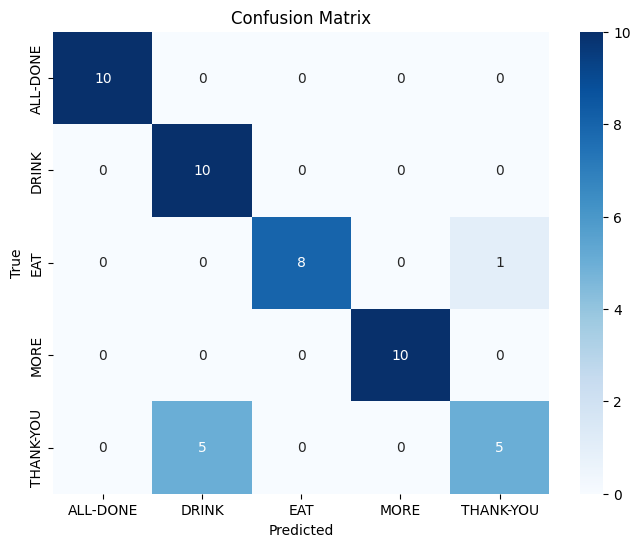

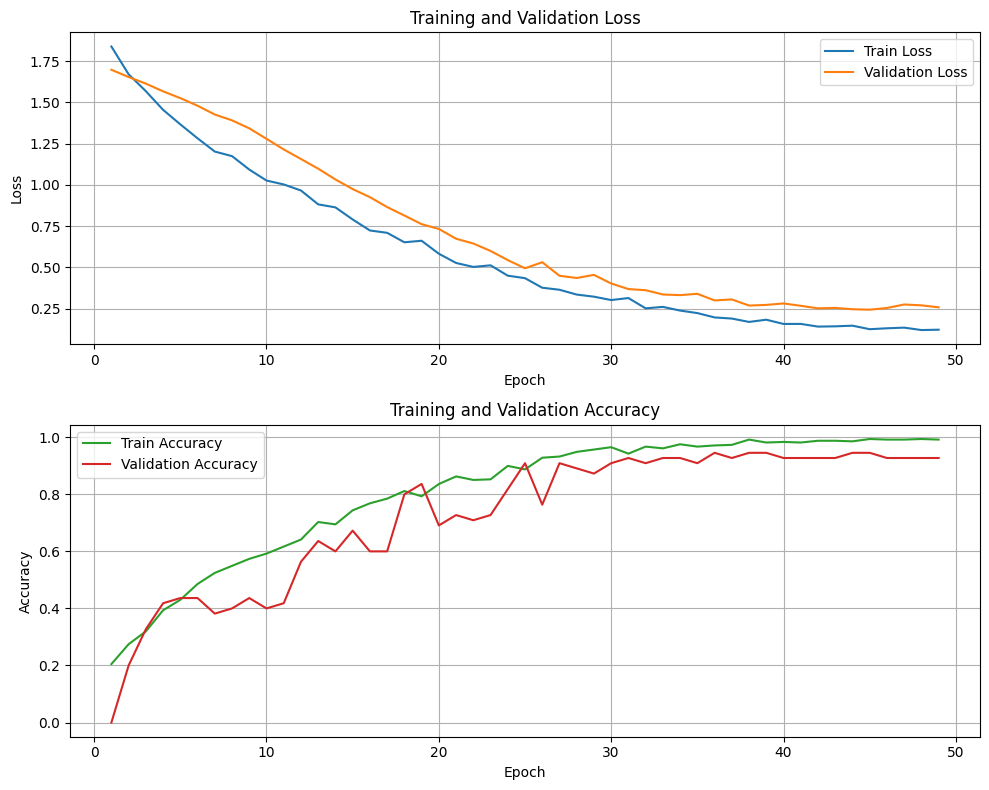

In [4]:
from keras._tf_keras.keras.models import load_model
model_dr = None
file ="model_dr.keras"
flags = False
if os.path.exists(file) or flags == True:
    model_dr = load_model(file)
    model_dr.compile(optimizer=SGD(learning_rate=1e-4, weight_decay=1e-6, momentum=0.97, nesterov=True, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
else:
    model_dr = Sequential([
        InputLayer(shape=(sequence_length, 2044)),  # Shape of the input
        Conv1D(filters=384, kernel_size=3, activation='relu', kernel_regularizer=L1L2()),
        MaxPooling1D(pool_size=3),
        Conv1D(filters=128, kernel_size=3, activation='tanh'),
        MaxPooling1D(pool_size=3),
        BatchNormalization(),

        Bidirectional(LSTM(376, return_sequences=True, kernel_regularizer=L2(1.0848960662999816e-05))),
        Dropout(0.354569645899713),
        Bidirectional(LSTM(352, return_sequences=True)),
        LSTM(120, kernel_regularizer=L2(6.142117138252424e-05)),
        LayerNormalization(),
        Activation('tanh'),
        Dense(100, activation='tanh'),
        Dropout(0.5),
        Dense(len(class_labels), activation='softmax')  # Output layer for classification
    ])

    model_dr.compile(optimizer=SGD(learning_rate=1e-4, weight_decay=1e-6, momentum=0.97, nesterov=True, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-12)	
history_dr = model_dr.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=100,  # Adjust epochs as needed
    batch_size=30,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model_dr.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_dr.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.ion()
plt.show()

# Extracting the history
train_loss = history_dr.history['loss']
val_loss = history_dr.history['val_loss']
train_acc = history_dr.history['accuracy']
val_acc = history_dr.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()

model_dr.save(f"model_dr{time.time_ns()}.keras")
import joblib


pd.DataFrame.to_csv(pd.DataFrame({"gesture":class_labels}), "class_labels.csv", index=False)

Trial 15 Complete [00h 00m 05s]

Best val_accuracy So Far: 0.9363636374473572
Total elapsed time: 01h 18m 25s
Epoch 1/100


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 366ms/step - accuracy: 0.9887 - loss: 0.6000 - val_accuracy: 0.9273 - val_loss: 0.7918 - learning_rate: 1.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.9808 - loss: 0.5980 - val_accuracy: 0.9273 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.9919 - loss: 0.5940 - val_accuracy: 0.9455 - val_loss: 0.7415 - learning_rate: 1.0000e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.9803 - loss: 0.6163 - val_accuracy: 0.9455 - val_loss: 0.6592 - learning_rate: 1.0000e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.9858 - loss: 0.5999 - val_accuracy: 0.9455 - val_loss: 0.7124 - learning_rate: 1.0000e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 1.0000 - loss: 0.5682 - val_accuracy: 0.9455 - val_loss: 0.7312 - learning_rate: 1.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.99

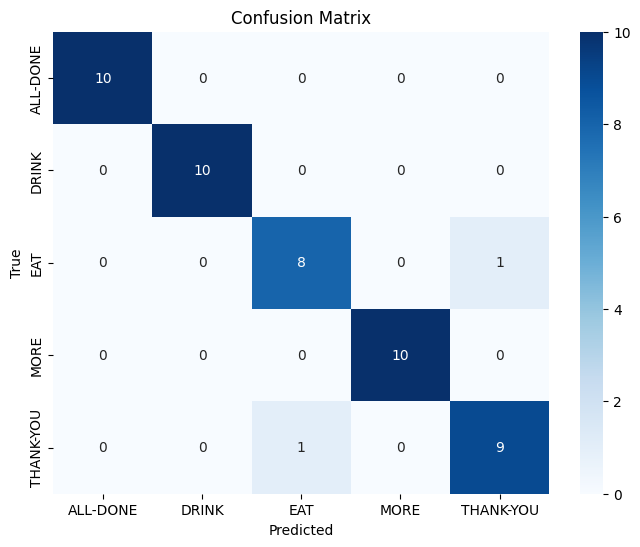

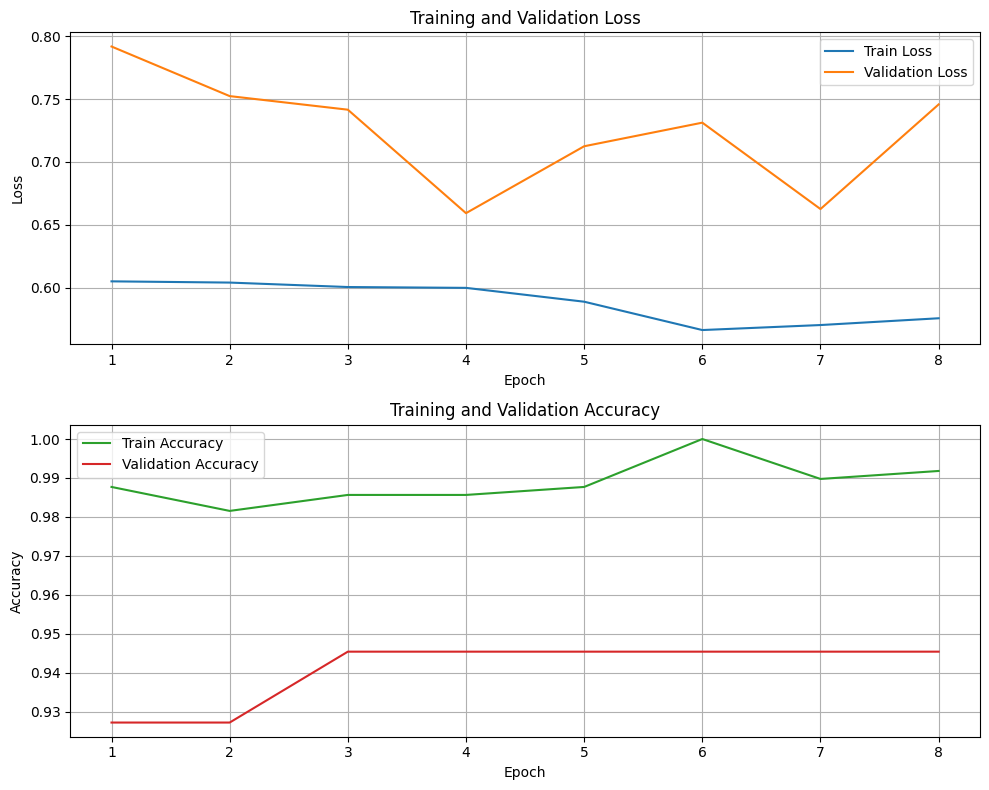

In [58]:

import keras_tuner as kt 
from keras_tuner.tuners import BayesianOptimization

activationst_list = ["relu", "leaky_relu", "tanh"]

def build_model(hp: kt.HyperParameters):
    model = Sequential([
    InputLayer(shape=(sequence_length, 2044)),  # Shape of the input
    Conv1D(filters=hp.Int("units_1", min_value=1, max_value=512), kernel_size=hp.Int("k_size", 1, 10), activation=hp.Choice("activation_1", activationst_list),
           kernel_regularizer=L1L2(hp.Float("l1", min_value=1e-6, max_value=1e-3, sampling="log"), hp.Float("l2", min_value=1e-6, max_value=1e-3, sampling="log"))),
    MaxPooling1D(pool_size=hp.Int("p_size1", min_value=1, max_value=2)),
    Conv1D(filters=hp.Int("units2", min_value=1, max_value=512), kernel_size=hp.Int("k_size", 1, 10), activation=hp.Choice("activation2", activationst_list)),
    # Dropout(hp.Float("drop1", min_value=1e-5, max_value=0.9)),
    MaxPooling1D(pool_size=hp.Int("p_size2", min_value=1, max_value=2)),
    Conv1D(filters=hp.Int("units2_5", min_value=1, max_value=512), kernel_size=hp.Int("k_size", 1, 10), activation=hp.Choice("activation2", activationst_list)),
    MaxPooling1D(pool_size=hp.Int("p_size3", min_value=1, max_value=2)),
    BatchNormalization(),

    Bidirectional(LSTM(hp.Int("units3", min_value=12, max_value=1024, step=32), return_sequences=True, kernel_regularizer=L2(hp.Float("l22", min_value=1e-6, max_value=1e-3, sampling="log")))),
    Dropout(hp.Float("drop2", min_value=0.1, max_value=0.9)),
    Bidirectional(LSTM(hp.Int("units4", min_value=24, max_value=1024, step=32), return_sequences=True)),
    LSTM(hp.Int("units5", min_value=24, max_value=512, step=32), kernel_regularizer=L2(hp.Float("l23", min_value=1e-6, max_value=1e-3, sampling="log"))),
    LayerNormalization(),
    Activation(activation=hp.Choice("Dense", activationst_list)),
    Dense(100, hp.Choice("Dense", ["relu", "tanh", "sigmoid"])),
    Dropout(hp.Float("drop3", min_value=0.1, max_value=0.6)),
    Dense(len(class_labels), activation='softmax')  # Output layer for classification
    ])
    model.compile(optimizer=SGD(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5]), weight_decay=1e-6, momentum=0.97, nesterov=True, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    # Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5]), weight_decay=1e-6, clipnorm=1.0),
    # RMSprop(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5]), weight_decay=1e-6, clipnorm=1.0)

    
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    directory='k_models',
    project_name='my_project_cnnlstm_v3'

)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-10)	
tuner.search(X_train_sequences, y_train_categorical, epochs=50, validation_data=(X_val_sequences, y_val_categorical), callbacks=[early_stopping, reduce_lr])


best_model = tuner.get_best_models()[0]

history = best_model.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=100,  # Adjust epochs as needed
    batch_size=30,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.ion()
plt.show()

# Extracting the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()


In [ ]:
best_model.save(f"best_095model{time.time_ns()}.keras")

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.2148 - loss: 1.7241 - val_accuracy: 0.2000 - val_loss: 1.6352 - learning_rate: 1.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.3177 - loss: 1.5822 - val_accuracy: 0.4182 - val_loss: 1.6036 - learning_rate: 1.0000e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.2812 - loss: 1.5286 - val_accuracy: 0.5818 - val_loss: 1.5712 - learning_rate: 1.0000e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.4416 - loss: 1.3859 - val_accuracy: 0.6909 - val_loss: 1.5325 - learning_rate: 1.0000e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.4360 - loss: 1.3161 - val_accuracy: 0.5455 - val_loss: 1.4844 - learning_rate: 1.0000e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5195 - loss: 1.2005 - val_accuracy: 0.5455 - val_loss: 1.4293 - learning_rate: 1.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - acc

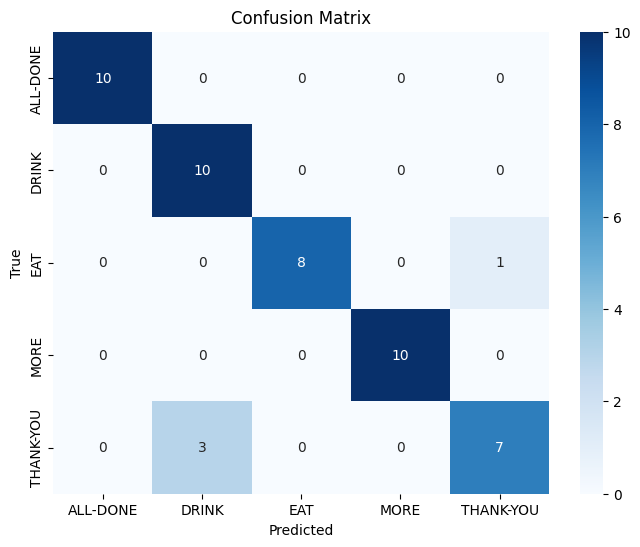

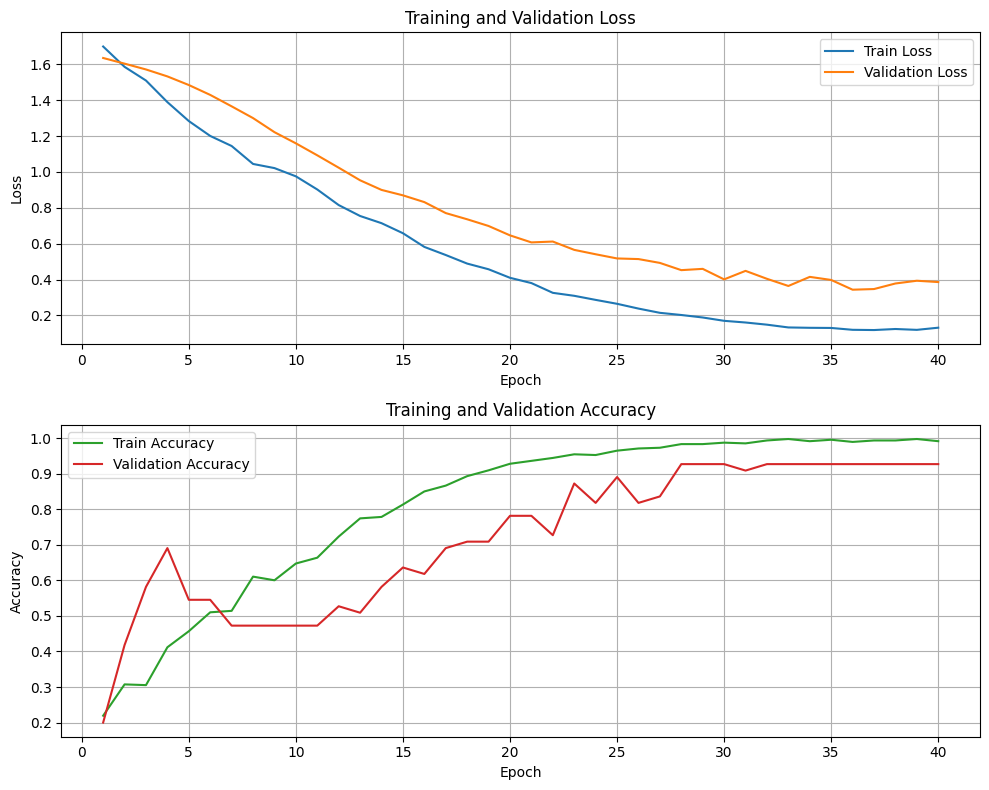

In [54]:
model_dev_1 = Sequential([
    InputLayer(shape=(sequence_length, 2044)),  # Shape of the input
    Conv1D(filters=384, kernel_size=3, activation='relu', kernel_regularizer=L1L2()),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='tanh'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='tanh'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Bidirectional(LSTM(376, return_sequences=True, kernel_regularizer=L2(1.0848960662999816e-05))),
    Dropout(0.354569645899713),
    Bidirectional(LSTM(352, return_sequences=True)),
    LSTM(120, kernel_regularizer=L2(6.142117138252424e-05)),
    LayerNormalization(),
    Activation('tanh'),
    Dense(100, activation='tanh'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')  # Output layer for classification
])

model_dev_1.compile(optimizer=SGD(learning_rate=1e-4, weight_decay=1e-6, momentum=0.97, nesterov=True, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-12)	
history_dev_1 = model_dev_1.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=100,  # Adjust epochs as needed
    batch_size=30,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_accuracy = model_dev_1.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


y_pred = model_dev_1.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.ion()
plt.show()

# Extracting the history
train_loss = history_dev_1.history['loss']
val_loss = history_dev_1.history['val_loss']
train_acc = history_dev_1.history['accuracy']
val_acc = history_dev_1.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()

In [55]:
model_dev_1.save(f"model_dev_1{time.time_ns()}.keras")